In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#load csv file
def load_data(file_index):
    df=pd.read_csv(f'./scratch/{file_index}.csv')
    A=np.array(df,dtype=complex)
    return A

In [46]:
def circular_moving_average(signals, hw):
        """循环移动平均，hw为半宽"""
        n_sig = signals.shape[1]
        smoothed = np.zeros_like(signals)
        
        for i in range(n_sig):
            # 循环索引：i-hw 到 i+hw
            indices = np.arange(i - hw, i + hw + 1) % n_sig
            smoothed[:,i] = np.mean(signals[:, indices], axis=1)
        
        return smoothed
def whole_pipeline(rd_data:np.ndarray):
    #perform dft on doppler axis
    n = rd_data.shape[1]
    dft_data = np.fft.fft(rd_data, axis=1)
    #compute spectral energy
    spectral_energy = np.abs(dft_data) ** 2/n
    #perform moving average for each range bin
    hw=int(np.round(n**0.8 / (4 * np.pi)))
    smoothed_energy = circular_moving_average(spectral_energy, hw=hw)
    epsilon=1e-10
    Lx = np.log(np.maximum(smoothed_energy, epsilon))
    return Lx

In [47]:
def coherent(array,n_pulse=256):
    n=array.shape[0]
    num_period=(int)(n/n_pulse)
    all_Ls=[]
    for i in range(num_period):
        A= array[i*n_pulse:(i+1)*n_pulse]
        A=A.transpose()
        Lx = whole_pipeline(A)
        all_Ls.append(Lx)
    conc=np.concatenate(all_Ls, axis=0)
    return conc

In [72]:
A=load_data(31)
conc=coherent(A)
conc.shape
norms=np.linalg.norm((conc-np.mean(conc,axis=0)),axis=1)
for i in range(14):
    indices=[i+14*k for k in range((int)(7154/14))]
    print(np.mean(norms[indices]))

16.15304837942423
15.196370352064609
17.19714981309681
23.156898242058123
24.68834045650597
24.368649015186197
23.0075179485267
18.790026611973826
14.547423621723304
14.491639023535168
15.03097511328491
15.16205896692164
15.57486551940082
15.943007502612351


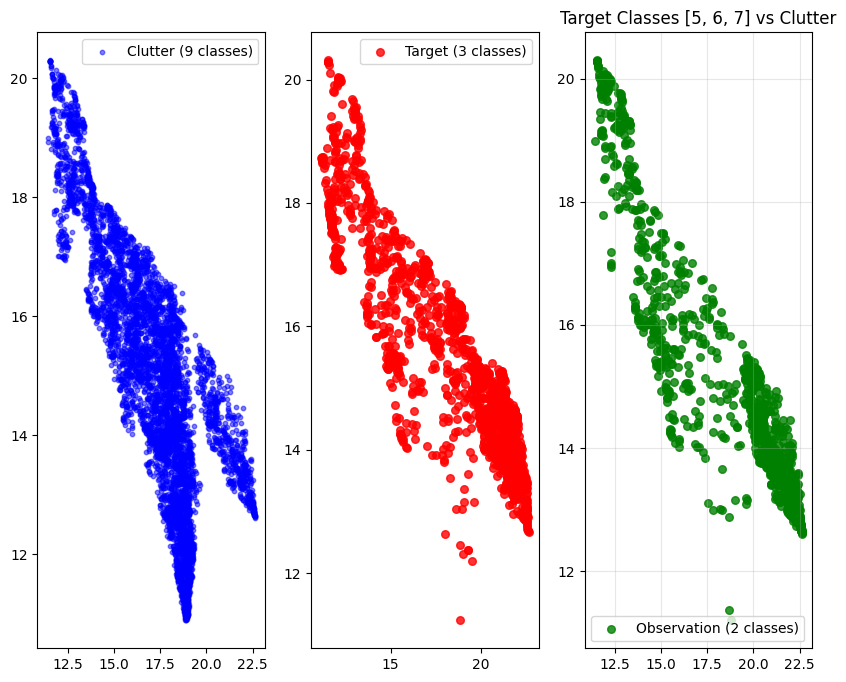

In [75]:
# Simple version to get started
import numpy as np
import umap
import matplotlib.pyplot as plt

# Your data
vectors = conc  # shape (7154, 256)

# Define which mod classes are targets
target_classes = [5,6,7]  # Change to your actual target classes
observation_class=[3,4]
# Create binary labels
labels = np.arange(7154) % 14
binary_labels = np.isin(labels, target_classes).astype(int)

# Run UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05)
embedding = reducer.fit_transform(vectors)

# Simple plot
#plot target, observation and clutter on three different plots

plt.figure(figsize=(10, 8))
#first figure
plt.subplot(1, 3, 1)
plt.scatter(embedding[binary_labels == 0, 0], embedding[binary_labels == 0, 1], 
            c='blue', s=10, alpha=0.5, label='Clutter (9 classes)')
plt.legend()
plt.subplot(1, 3, 2)
plt.scatter(embedding[binary_labels == 1, 0], embedding[binary_labels == 1, 1], 
            c='red', s=30, alpha=0.8, label='Target (3 classes)')
plt.legend()
plt.subplot(1, 3, 3)
plt.scatter(embedding[np.isin(labels, observation_class), 0], embedding[np.isin(labels, observation_class), 1],
            c='green', s=30, alpha=0.8, label='Observation (2 classes)')

plt.legend()
plt.title(f'Target Classes {target_classes} vs Clutter')
plt.grid(alpha=0.3)
plt.show()

Normalizing data...
Running UMAP...
UMAP(n_epochs=1000, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Thu Dec 25 00:24:08 2025 Construct fuzzy simplicial set
Thu Dec 25 00:24:08 2025 Finding Nearest Neighbors
Thu Dec 25 00:24:08 2025 Building RP forest with 9 trees
Thu Dec 25 00:24:08 2025 NN descent for 13 iterations
	 1  /  13


/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu Dec 25 00:24:09 2025 Finished Nearest Neighbor Search
Thu Dec 25 00:24:09 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Dec 25 00:24:42 2025 Finished embedding


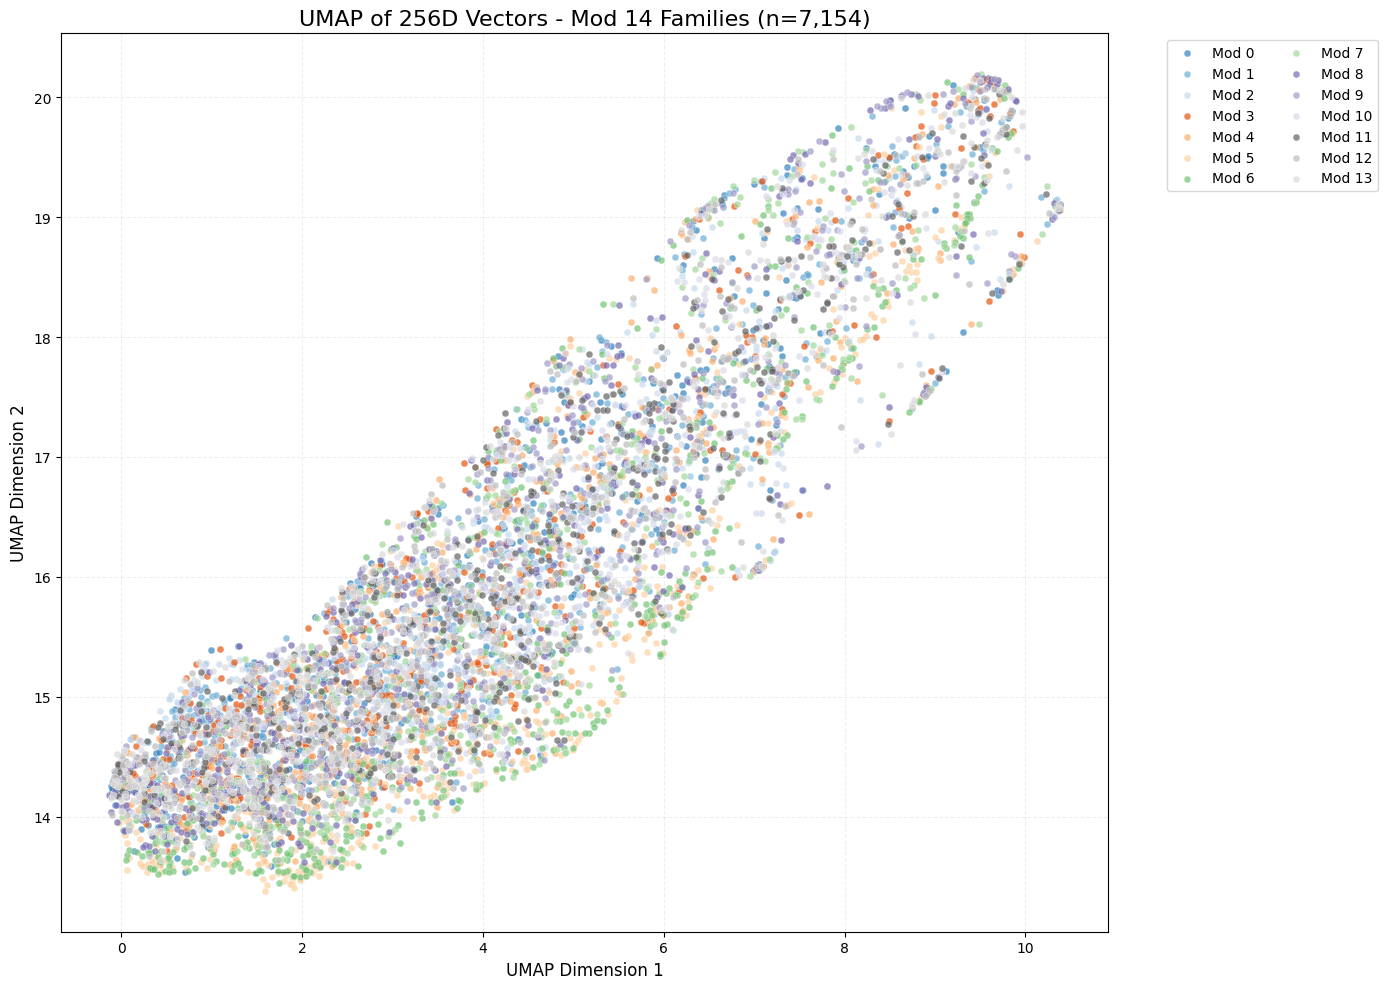

In [64]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Assuming your data
# vectors.shape = (7154, 256)
# labels = vectors mod 14 (0-13)

# Generate labels if you haven't already
# labels = vector_indices % 14  # or however your family is defined

def visualize_mod14_umap(vectors, labels):
    """
    Optimized UMAP for 7,154 vectors with 14 classes (mod 14 families).
    """
    
    # 1. Normalize the data (critical for 256D)
    print("Normalizing data...")
    scaler = StandardScaler()
    vectors_norm = scaler.fit_transform(vectors)
    
    # 2. UMAP with parameters tuned for 7K samples
    print("Running UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=30,        # Slightly higher for 7K samples
        min_dist=0.1,          # Good separation between clusters
        metric='euclidean',    # Try 'cosine' if vectors are normalized
        n_epochs=1000,         # Ensure convergence
        random_state=42,       # Reproducibility
        verbose=True
    )
    
    embedding = reducer.fit_transform(vectors_norm)
    
    # 3. Create beautiful visualization
    plt.figure(figsize=(14, 10))
    
    # Color palette for 14 distinct classes
    colors = plt.cm.tab20c(np.linspace(0, 1, 14))
    
    # Plot each class
    for class_id in range(14):
        mask = labels == class_id
        plt.scatter(
            embedding[mask, 0], 
            embedding[mask, 1],
            s=25,               # Slightly larger for visibility
            alpha=0.7,
            color=colors[class_id],
            label=f'Mod {class_id}',
            edgecolors='white',
            linewidth=0.3
        )
    
    plt.title(f'UMAP of 256D Vectors - Mod 14 Families (n=7,154)', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    
    # Add legend outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
               fontsize=10, ncol=2)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    return embedding, reducer

# Usage
labels = np.arange(7154) % 14
embedding, reducer = visualize_mod14_umap(conc, labels)

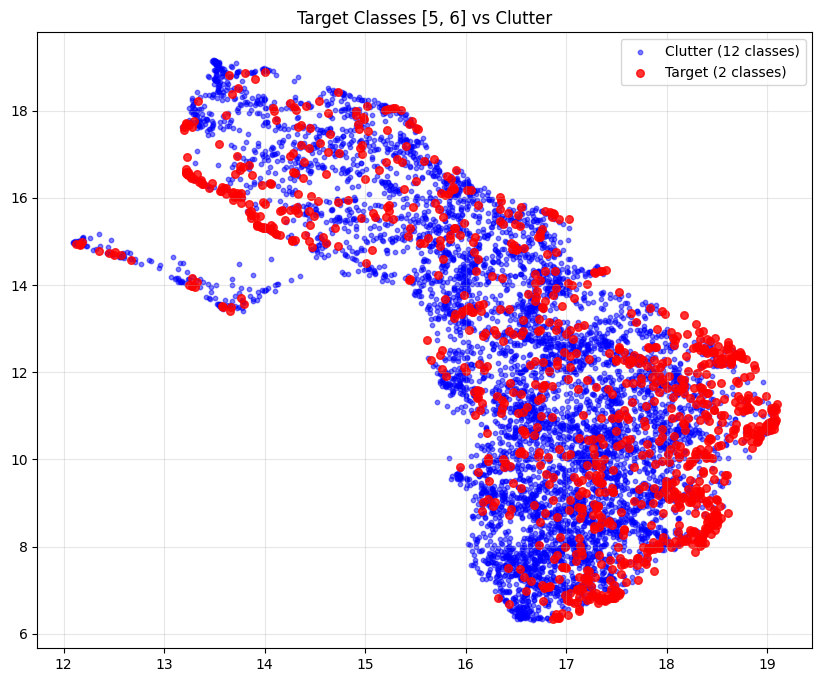

/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Best Configuration ===
Name: Local Focus
Silhouette Score: 0.1513
Parameters: n_neighbors=10, min_dist=0.01, metric=euclidean


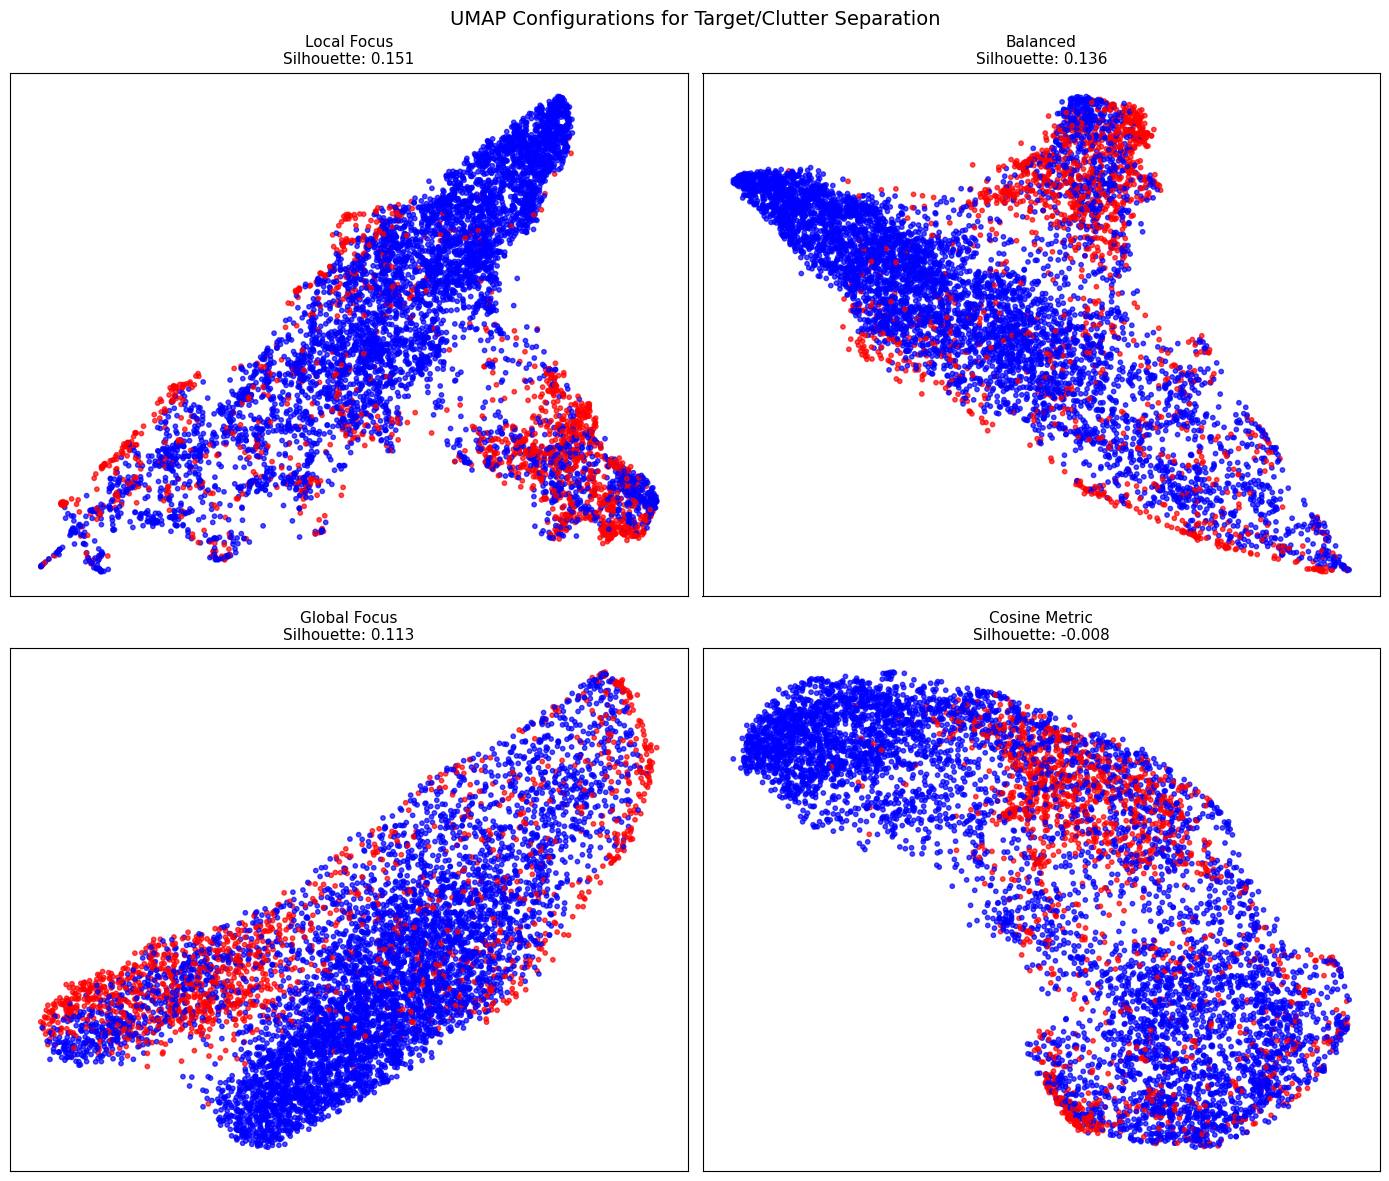

In [76]:
def optimize_target_separation(vectors, target_classes):
    """
    Try different techniques to maximize target/clutter separation.
    """
    labels = np.arange(len(vectors)) % 14
    binary_labels = np.isin(labels, target_classes).astype(int)
    
    scaler = StandardScaler()
    vectors_norm = scaler.fit_transform(vectors)
    
    # Try different UMAP configurations
    configurations = [
        {'n_neighbors': 10, 'min_dist': 0.01, 'metric': 'euclidean', 'name': 'Local Focus'},
        {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'euclidean', 'name': 'Balanced'},
        {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'euclidean', 'name': 'Global Focus'},
        {'n_neighbors': 15, 'min_dist': 0.05, 'metric': 'cosine', 'name': 'Cosine Metric'},
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    best_score = -1
    best_embedding = None
    best_config = None
    
    for ax, config in zip(axes, configurations):
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=config['n_neighbors'],
            min_dist=config['min_dist'],
            metric=config['metric'],
            random_state=42
        )
        
        embedding = reducer.fit_transform(vectors_norm)
        
        # Color: red for targets, blue for clutter
        colors = ['blue' if label == 0 else 'red' for label in binary_labels]
        
        ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=colors,
            s=10,
            alpha=0.7
        )
        
        # Calculate silhouette score
        from sklearn.metrics import silhouette_score
        score = silhouette_score(embedding, binary_labels)
        
        ax.set_title(f"{config['name']}\nSilhouette: {score:.3f}", fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=0.2)
        
        # Track best configuration
        if score > best_score:
            best_score = score
            best_embedding = embedding
            best_config = config
    
    plt.suptitle('UMAP Configurations for Target/Clutter Separation', fontsize=14)
    plt.tight_layout()
    
    print(f"\n=== Best Configuration ===")
    print(f"Name: {best_config['name']}")
    print(f"Silhouette Score: {best_score:.4f}")
    print(f"Parameters: n_neighbors={best_config['n_neighbors']}, "
          f"min_dist={best_config['min_dist']}, metric={best_config['metric']}")
    
    return best_embedding, best_config

best_embedding,best_config = optimize_target_separation(conc, target_classes=[5,6,7])

In [112]:
import numpy as np
from scipy import signal

def cfar_2d_svi(data, guard_cells=2, training_cells=10, pfa=1e-6):
    """
    2D CFAR using Square Law Detector and Cell-Averaging (CA-CFAR)
    
    Parameters:
    - data: 2D array [pulses × range_bins]
    - guard_cells: Cells around CUT to exclude from averaging
    - training_cells: Cells to use for noise estimation
    - pfa: Probability of false alarm
    
    Returns:
    - detection_mask: Boolean array where True indicates target detection
    """
    num_pulses, num_range_bins = data.shape
    detection_mask = np.zeros_like(data, dtype=bool)
    
    # Convert to power domain (square law detector)
    power_data = np.abs(data) ** 2
    
    # Calculate threshold multiplier (alpha)
    alpha = training_cells * (pfa ** (-1.0 / training_cells) - 1)
    
    # Pad the data to handle edges
    pad_size = guard_cells + training_cells
    padded_data = np.pad(power_data, pad_size, mode='reflect')
    
    # Iterate through each cell under test (excluding padded regions)
    for i in range(pad_size, num_pulses + pad_size):
        for j in range(pad_size, num_range_bins + pad_size):
            # Define regions
            # Leading and lagging in range dimension
            range_train = []
            # Leading range cells
            if j - guard_cells - training_cells >= 0:
                range_train.append(padded_data[i, j - guard_cells - training_cells:j - guard_cells])
            # Lagging range cells
            if j + guard_cells + training_cells < padded_data.shape[1]:
                range_train.append(padded_data[i, j + guard_cells + 1:j + guard_cells + training_cells + 1])
            
            # Leading and lagging in pulse/Doppler dimension
            doppler_train = []
            # Leading pulse cells
            if i - guard_cells - training_cells >= 0:
                doppler_train.append(padded_data[i - guard_cells - training_cells:i - guard_cells, j])
            # Lagging pulse cells
            if i + guard_cells + training_cells < padded_data.shape[0]:
                doppler_train.append(padded_data[i + guard_cells + 1:i + guard_cells + training_cells + 1, j])
            
            # Combine all training cells
            if range_train or doppler_train:
                all_train = np.concatenate([arr.flatten() for arr in range_train + doppler_train])
                if len(all_train) > 0:
                    # Estimate noise level
                    noise_estimate = np.mean(all_train)
                    # Calculate threshold
                    threshold = alpha * noise_estimate
                    # Check detection
                    if padded_data[i, j] > threshold:
                        detection_mask[i - pad_size, j - pad_size] = True
    
    return detection_mask

def process_by_cpi(data, cpi_length=256, cfar_params=None):
    """
    Process data in CPI blocks
    
    Parameters:
    - data: Original data [130171 pulses × 14 range_bins]
    - cpi_length: Length of each CPI (256)
    - cfar_params: Dictionary of CFAR parameters
    
    Returns:
    - all_detections: List of detection masks for each CPI
    - processed_data: Array of processed data (optional)
    """
    if cfar_params is None:
        cfar_params = {
            'guard_cells': 2,
            'training_cells': 8,
            'pfa': 0.0001
        }
    
    num_pulses, num_range_bins = data.shape
    num_cpis = num_pulses // cpi_length
    
    all_detections = []
    
    for cpi_idx in range(num_cpis):
        # Extract CPI block
        start_idx = cpi_idx * cpi_length
        end_idx = start_idx + cpi_length
        cpi_data = data[start_idx:end_idx, :]
        
        # Perform CFAR on this CPI
        detections = cfar_2d_svi(cpi_data, **cfar_params)
        all_detections.append(detections)
        
        # Optional: Apply Doppler processing here
        # cpi_range_doppler = np.fft.fft(cpi_data, axis=0)
    
    return all_detections

In [113]:
def extract_target_locations(all_detections, cpi_length=256):
    """
    Extract target locations from CFAR detection results
    
    Parameters:
    - all_detections: List of detection masks from each CPI
    - cpi_length: Number of pulses per CPI (256)
    
    Returns:
    - targets: List of dictionaries with target information
    - detection_matrix: Consolidated detection matrix
    """
    num_cpis = len(all_detections)
    num_range_bins = all_detections[0].shape[1]  # Should be 14
    
    # Initialize consolidated detection matrix
    detection_matrix = np.zeros((num_cpis * cpi_length, num_range_bins), dtype=bool)
    targets = []
    
    # Process each CPI
    for cpi_idx, det_mask in enumerate(all_detections):
        # Find where detections occurred in this CPI
        det_indices = np.argwhere(det_mask)  # Returns [pulse_in_cpi, range_bin] pairs
        
        # Convert to global pulse indices
        global_pulse_start = cpi_idx * cpi_length
        
        for pulse_in_cpi, range_bin in det_indices:
            global_pulse = global_pulse_start + pulse_in_cpi
            
            # Update consolidated matrix
            detection_matrix[global_pulse, range_bin] = True
            
            # Create target entry
            target_info = {
                'cpi_index': cpi_idx,
                'pulse_in_cpi': pulse_in_cpi,
                'global_pulse': global_pulse,
                'range_bin': range_bin,
                'detection_time': global_pulse,  # Could convert to actual time
                'cpi_center_time': global_pulse_start + cpi_length/2
            }
            targets.append(target_info)
    
    return targets, detection_matrix

In [114]:
def group_detections_into_tracks(detection_matrix, min_pulses=3, max_gap=5):
    """
    Group detections into potential target tracks
    
    Parameters:
    - detection_matrix: Boolean matrix of detections [pulses × range_bins]
    - min_pulses: Minimum consecutive detections to form a track
    - max_gap: Maximum allowed gap in pulses for track continuation
    
    Returns:
    - tracks: List of track dictionaries
    """
    num_pulses, num_range_bins = detection_matrix.shape
    tracks = []
    visited = np.zeros_like(detection_matrix, dtype=bool)
    
    for range_bin in range(num_range_bins):
        pulse = 0
        while pulse < num_pulses:
            if detection_matrix[pulse, range_bin] and not visited[pulse, range_bin]:
                # Start new track
                track_pulses = []
                current_pulse = pulse
                
                # Collect consecutive or closely spaced detections
                while current_pulse < num_pulses:
                    if detection_matrix[current_pulse, range_bin]:
                        track_pulses.append(current_pulse)
                        visited[current_pulse, range_bin] = True
                        current_pulse += 1
                    else:
                        # Check for small gaps
                        gap = 0
                        while (current_pulse + gap < num_pulses and 
                               gap <= max_gap and 
                               not detection_matrix[current_pulse + gap, range_bin]):
                            gap += 1
                        
                        if gap <= max_gap and current_pulse + gap < num_pulses:
                            # Fill the gap
                            for g in range(gap):
                                track_pulses.append(current_pulse + g)
                            current_pulse += gap
                        else:
                            break
                
                # If track is long enough, save it
                if len(track_pulses) >= min_pulses:
                    track_info = {
                        'range_bin': range_bin,
                        'pulses': track_pulses,
                        'start_pulse': min(track_pulses),
                        'end_pulse': max(track_pulses),
                        'duration': len(track_pulses),
                        'range_bin_center': range_bin,  # Could convert to actual range
                        'detection_count': len([p for p in track_pulses 
                                               if detection_matrix[p, range_bin]])
                    }
                    tracks.append(track_info)
                
                pulse = current_pulse
            else:
                pulse += 1
    
    return tracks

In [115]:
def analyze_cpi_targets(data, all_detections, cpi_length=256):
    """
    Analyze Doppler characteristics of targets in each CPI
    
    Parameters:
    - data: Original complex radar data [pulses × range_bins]
    - all_detections: CFAR detection masks for each CPI
    - cpi_length: Pulses per CPI (256)
    
    Returns:
    - target_doppler_info: List of target Doppler characteristics
    """
    target_doppler_info = []
    num_cpis = len(all_detections)
    
    for cpi_idx in range(num_cpis):
        # Extract CPI data
        start_pulse = cpi_idx * cpi_length
        end_pulse = start_pulse + cpi_length
        cpi_data = data[start_pulse:end_pulse, :]
        
        # Get Doppler spectrum via FFT
        doppler_spectrum = np.fft.fft(cpi_data, axis=0)
        doppler_power = np.abs(doppler_spectrum) ** 2
        
        # Get detections for this CPI
        det_mask = all_detections[cpi_idx]
        det_indices = np.argwhere(det_mask)
        
        for pulse_in_cpi, range_bin in det_indices:
            # Extract Doppler profile for this range bin
            doppler_profile = doppler_power[:, range_bin]
            
            # Find peak Doppler bin (convert to frequency/velocity)
            peak_doppler_bin = np.argmax(doppler_profile)
            
            # Convert to Doppler frequency (assuming PRF is known)
            # doppler_freq = (peak_doppler_bin - cpi_length/2) * (prf / cpi_length)
            
            target_info = {
                'cpi_index': cpi_idx,
                'global_pulse': start_pulse + pulse_in_cpi,
                'range_bin': range_bin,
                'pulse_in_cpi': pulse_in_cpi,
                'doppler_bin': peak_doppler_bin,
                'doppler_power': doppler_profile[peak_doppler_bin],
                'mean_power': np.mean(doppler_profile),
                'snr_db': 10 * np.log10(doppler_profile[peak_doppler_bin] / 
                                       np.mean(doppler_profile))
            }
            target_doppler_info.append(target_info)
    
    return target_doppler_info

In [116]:
def complete_target_analysis(data, all_detections, cpi_length=256):
    """
    Complete pipeline: Extract, group, and analyze targets
    
    Returns comprehensive target information
    """
    # 1. Extract basic target locations
    targets, detection_matrix = extract_target_locations(all_detections, cpi_length)
    
    # 2. Group into tracks
    tracks = group_detections_into_tracks(detection_matrix, min_pulses=5, max_gap=3)
    
    # 3. Analyze Doppler characteristics
    doppler_info = analyze_cpi_targets(data, all_detections, cpi_length)
    
    # 4. Consolidate information
    consolidated_targets = []
    
    # Match Doppler info with basic detections
    for target in targets:
        # Find matching Doppler info
        doppler_match = None
        for doppler in doppler_info:
            if (doppler['cpi_index'] == target['cpi_index'] and 
                doppler['range_bin'] == target['range_bin'] and
                doppler['pulse_in_cpi'] == target['pulse_in_cpi']):
                doppler_match = doppler
                break
        
        # Find if this target belongs to a track
        track_match = None
        for track in tracks:
            if (track['range_bin'] == target['range_bin'] and 
                target['global_pulse'] in track['pulses']):
                track_match = track
                break
        
        # Create consolidated target entry
        consolidated = {
            'location': {
                'global_pulse': target['global_pulse'],
                'range_bin': target['range_bin'],
                'cpi_index': target['cpi_index']
            },
            'doppler': doppler_match,
            'track_info': track_match,
            'detection_confidence': 1.0  # Could calculate based on SNR, persistence
        }
        consolidated_targets.append(consolidated)
    
    # 5. Statistical summary
    summary = {
        'total_detections': len(targets),
        'total_tracks': len(tracks),
        'detections_per_range': np.sum(detection_matrix, axis=0),
        'detections_per_cpi': [np.sum(det) for det in all_detections],
        'mean_track_length': np.mean([t['duration'] for t in tracks]) if tracks else 0,
        'range_bin_activity': {
            'most_active': int(np.argmax(np.sum(detection_matrix, axis=0))),
            'least_active': int(np.argmin(np.sum(detection_matrix, axis=0)))
        }
    }
    
    return consolidated_targets, summary, detection_matrix

In [117]:
import matplotlib.pyplot as plt

def plot_target_locations(detection_matrix, tracks=None, title="CFAR Target Detections"):
    """
    Plot target detections and tracks
    """
    num_pulses, num_range_bins = detection_matrix.shape
    
    plt.figure(figsize=(14, 8))
    
    # Create detection plot
    det_pulses, det_ranges = np.where(detection_matrix)
    plt.scatter(det_pulses, det_ranges, 
                c='red', s=20, marker='o', 
                alpha=0.6, label='Individual Detections')
    
    # Overlay tracks if available
    if tracks:
        for track in tracks:
            track_pulses = track['pulses']
            track_range = [track['range_bin']] * len(track_pulses)
            plt.plot(track_pulses, track_range, 
                    'b-', linewidth=2, alpha=0.7, 
                    label='Track' if track == tracks[0] else "")
    
    plt.xlabel('Pulse Index', fontsize=12)
    plt.ylabel('Range Bin', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.colorbar(label='Detection Intensity')
    plt.tight_layout()
    plt.show()

def plot_range_time_intensity(data, detection_matrix):
    """
    Plot range-time intensity with detections overlaid
    """
    plt.figure(figsize=(14, 8))
    
    # Plot background power
    power_db = 10 * np.log10(np.abs(data) ** 2 + 1e-10)
    plt.imshow(power_db.T, aspect='auto', cmap='viridis',
               origin='lower', alpha=0.7,
               extent=[0, data.shape[0], 0, data.shape[1]])
    
    # Overlay detections
    det_pulses, det_ranges = np.where(detection_matrix)
    plt.scatter(det_pulses, det_ranges, 
                c='red', s=10, marker='x',
                alpha=0.9, label='CFAR Detections')
    
    plt.colorbar(label='Power (dB)')
    plt.xlabel('Pulse Index', fontsize=12)
    plt.ylabel('Range Bin', fontsize=12)
    plt.title('Range-Time Intensity with CFAR Detections', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

Total detections: 214
Number of tracks: 0
Detections per range bin: [51 27  0  0  0  0 34 54  0  0  0  0  9 39]
Average track length: 0.00 pulses

First 10 target detections:
Target 0: Pulse 237, Range Bin 0, CPI 0
Target 1: Pulse 675, Range Bin 0, CPI 2
Target 2: Pulse 1290, Range Bin 0, CPI 5
Target 3: Pulse 1355, Range Bin 0, CPI 5
Target 4: Pulse 1687, Range Bin 0, CPI 6
Target 5: Pulse 1947, Range Bin 0, CPI 7
Target 6: Pulse 1947, Range Bin 1, CPI 7
Target 7: Pulse 1948, Range Bin 0, CPI 7
Target 8: Pulse 1948, Range Bin 1, CPI 7
Target 9: Pulse 3648, Range Bin 6, CPI 14


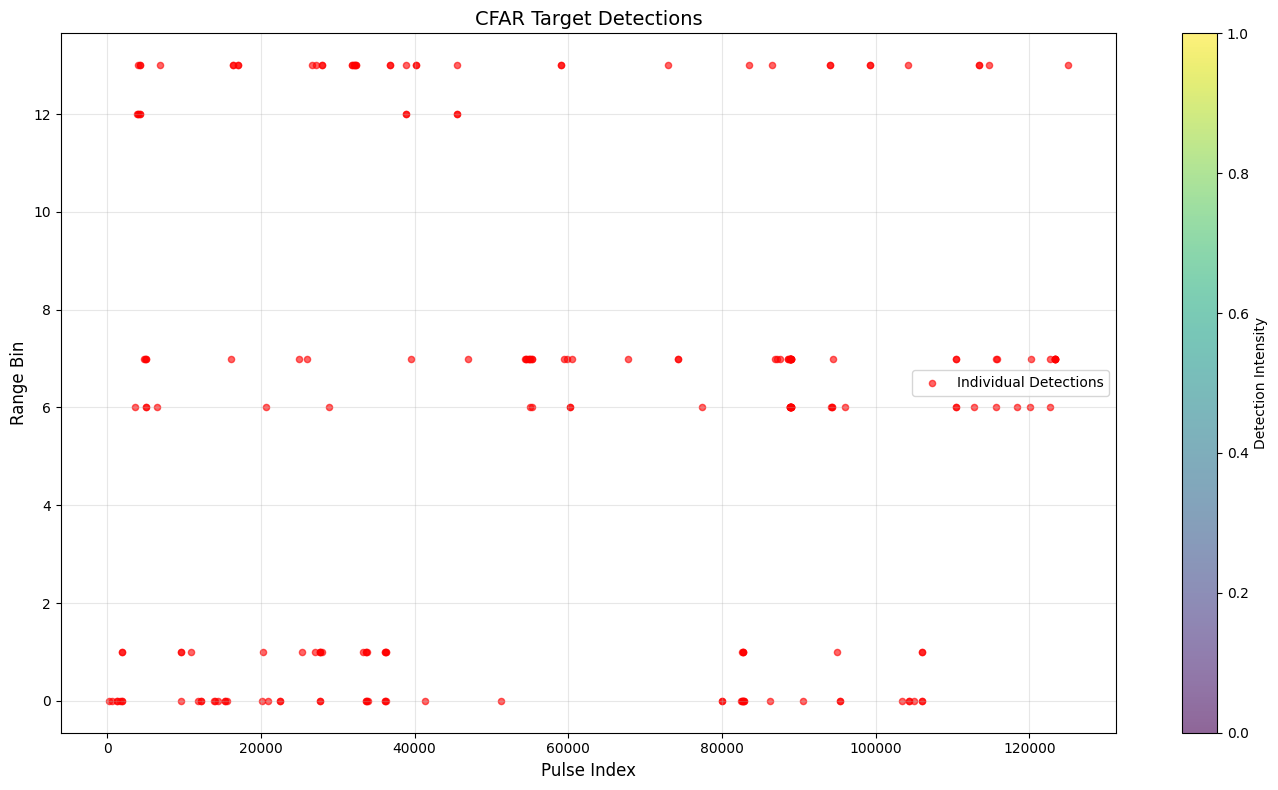

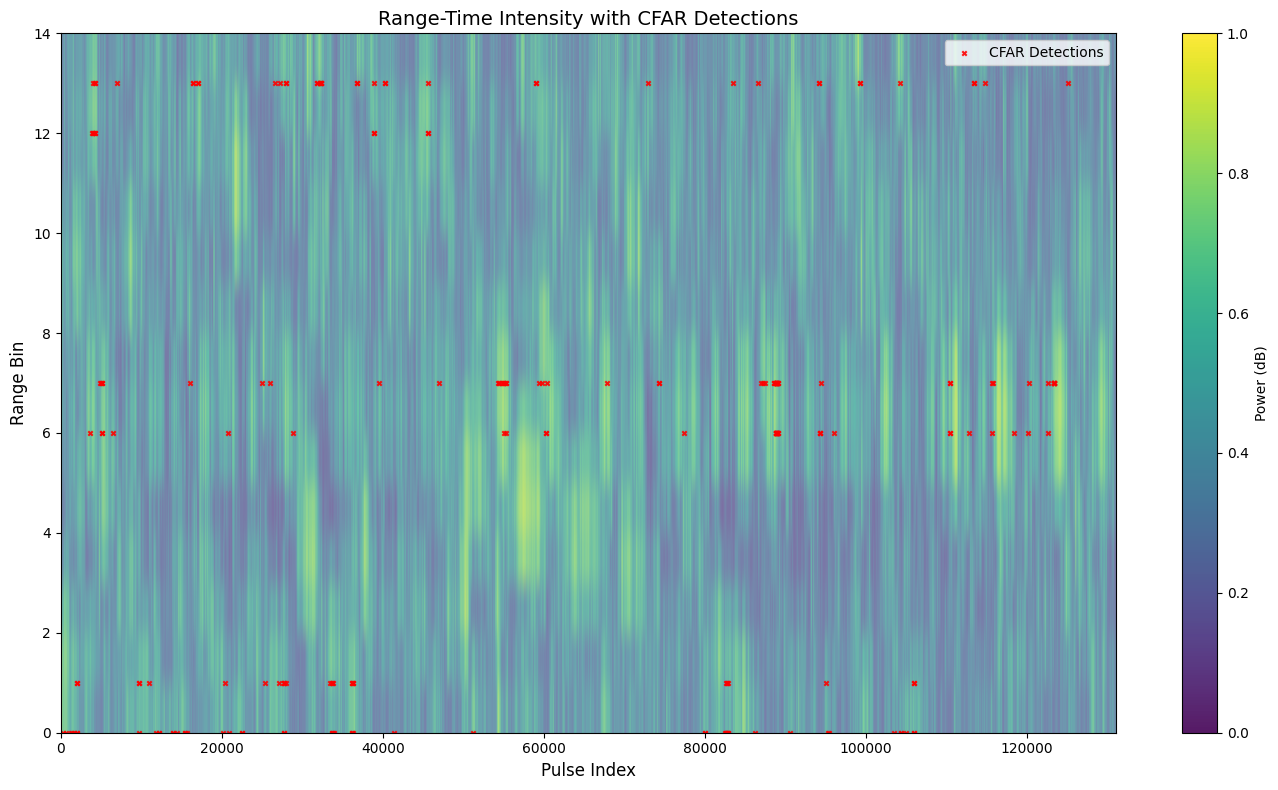

In [118]:
# Assuming you've already run CFAR and have all_detections
all_detections = process_by_cpi(A, cpi_length=256)

# Complete analysis
targets, summary, det_matrix = complete_target_analysis(A, all_detections)

# Print summary
print(f"Total detections: {summary['total_detections']}")
print(f"Number of tracks: {summary['total_tracks']}")
print(f"Detections per range bin: {summary['detections_per_range']}")
print(f"Average track length: {summary['mean_track_length']:.2f} pulses")

# Print first few targets
print("\nFirst 10 target detections:")
for i, target in enumerate(targets[:10]):
    loc = target['location']
    print(f"Target {i}: Pulse {loc['global_pulse']}, Range Bin {loc['range_bin']}, "
          f"CPI {loc['cpi_index']}")

# Visualize
plot_target_locations(det_matrix)
plot_range_time_intensity(A, det_matrix)

# # Save results
# import pandas as pd
# targets_df = pd.DataFrame([t['location'] for t in targets])
# targets_df.to_csv('cfar_detections.csv', index=False)